In [52]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
path = 'data/df_analyze.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)

In [5]:
dfgame['H_Pass_Score'] = (dfgame['H_O_Pass_Rank'] + dfgame['V_D_Pass_Rank'])/2.0
dfgame['H_Rush_Score'] = (dfgame['H_O_Rush_Rank'] + dfgame['V_D_Rush_Rank'])/2.0
dfgame['V_Pass_Score'] = (dfgame['V_O_Pass_Rank'] + dfgame['H_D_Pass_Rank'])/2.0
dfgame['V_Rush_Score'] = (dfgame['V_O_Rush_Rank'] + dfgame['H_D_Rush_Rank'])/2.0
dfrank = pd.concat([dfgame.pop(x) for x in ['H_O_Pass_Rank','H_O_Rush_Rank','V_O_Pass_Rank','V_O_Rush_Rank',
                                            'V_D_Pass_Rank','V_D_Rush_Rank','H_D_Pass_Rank','H_D_Rush_Rank']],
                                            axis=1)

In [6]:
dfgame['H_FG_Pct'] = dfgame['H_FG_Made']/dfgame['H_FG_Att']
dfgame['V_FG_Pct'] = dfgame['V_FG_Made']/dfgame['V_FG_Att']
dffg = pd.concat([dfgame.pop(x) for x in ['H_FG_Made','H_FG_Att','V_FG_Made','V_FG_Att']],axis=1)

In [7]:
dfgame['H_RZ_Pct'] = dfgame['H_RZ_Conv']/dfgame['H_RZ_Att']
dfgame['V_RZ_Pct'] = dfgame['V_RZ_Conv']/dfgame['V_RZ_Att']
dfgame['H_Def_RZ_Pct'] = dfgame['H_RZ_Def_Conv']/dfgame['H_RZ_Def_Att']
dfgame['V_Def_RZ_Pct'] = dfgame['V_RZ_Def_Conv']/dfgame['V_RZ_Def_Att']
dfrz = pd.concat([dfgame.pop(x) for x in ['H_RZ_Conv','H_RZ_Att','V_RZ_Conv','V_RZ_Att']],axis=1)
dfrzdef = pd.concat([dfgame.pop(x) for x in ['H_RZ_Def_Conv','H_RZ_Def_Att','V_RZ_Def_Conv','V_RZ_Def_Att']],
                    axis=1)

In [8]:
dfgame = pd.concat([dfgame.drop('Surface', axis = 1), pd.get_dummies(dfgame.Surface)], axis = 1)

In [9]:
new_gcols=['Over/Under','Tot_Pts','H_Pts','V_Pts','H_Pts_Opp','V_Pts_Opp','H_Off_Pass','H_Pass_Score','V_Off_Pass','V_Pass_Score',
        'H_Off_Rush','H_Rush_Score','V_Off_Rush','V_Rush_Score','H_Def_Pass','V_Def_Pass','H_Def_Rush','V_Def_Rush',
        'H_TD','V_TD','H_TD_on_Def','V_TD_on_Def','H_FG_Pct','V_FG_Pct','H_RZ_Pct','V_RZ_Pct','H_Def_RZ_Pct',
        'V_Def_RZ_Pct','H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost',
        'H_Yds_Pen','V_Yds_Pen','H_Sacks_Def','V_Sacks_Def','H_Tackles_Loss','V_Tackles_Loss','H_Kickret',
        'V_Kickret','H_Puntret','V_Puntret','Temperature','a_turf','astroplay','astroturf','fieldturf','grass','matrixturf','sportturf']

In [10]:
dfgame=dfgame[new_gcols]

In [11]:
dfgame

,Over/Under,Tot_Pts,H_Pts,V_Pts,H_Pts_Opp,V_Pts_Opp,H_Off_Pass,H_Pass_Score,V_Off_Pass,V_Pass_Score,...,H_Puntret,V_Puntret,Temperature,a_turf,astroplay,astroturf,fieldturf,grass,matrixturf,sportturf
Code,,,,,,,,,,,,,,,,,,,,,
201010170phi,43.0,48,24.4,22.6,20.6,14.0,255.4,19.0,233.0,20.5,...,13.446667,7.000000,66,0,0,0,0,1,0,0
201010240atl,43.0,71,24.2,20.0,17.2,20.4,232.6,19.5,257.4,15.5,...,8.600000,2.433333,70,0,0,0,1,0,0,0
201011070atl,45.5,48,23.8,19.8,22.2,28.4,247.4,21.5,252.2,11.5,...,6.200000,5.266667,70,0,0,0,1,0,0,0
201011110atl,44.0,47,23.8,26.2,21.6,19.6,248.8,12.5,253.2,14.5,...,6.200000,1.066667,70,0,0,0,1,0,0,0
201011210ram,43.5,51,16.6,25.8,22.4,23.0,196.2,5.5,257.4,18.5,...,8.666667,7.800000,70,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912010rav,45.0,37,40.4,35.2,12.4,19.8,198.4,17.5,283.4,26.0,...,5.400000,4.633333,40,0,0,0,0,1,0,0
201911030sea,51.0,74,26.4,31.8,23.4,33.4,245.2,9.0,334.0,18.0,...,2.933333,4.293333,54,0,0,0,1,0,0,0
201911110sfo,47.0,51,27.8,29.0,9.6,28.2,213.4,6.0,272.8,26.5,...,13.766667,4.866667,77,0,0,0,0,1,0,0


In [12]:
dfgame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1734 entries, 201010170phi to 201910200was
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Over/Under      1734 non-null   float64
 1   Tot_Pts         1734 non-null   int64  
 2   H_Pts           1734 non-null   float64
 3   V_Pts           1734 non-null   float64
 4   H_Pts_Opp       1734 non-null   float64
 5   V_Pts_Opp       1734 non-null   float64
 6   H_Off_Pass      1734 non-null   float64
 7   H_Pass_Score    1734 non-null   float64
 8   V_Off_Pass      1734 non-null   float64
 9   V_Pass_Score    1734 non-null   float64
 10  H_Off_Rush      1734 non-null   float64
 11  H_Rush_Score    1734 non-null   float64
 12  V_Off_Rush      1734 non-null   float64
 13  V_Rush_Score    1734 non-null   float64
 14  H_Def_Pass      1734 non-null   float64
 15  V_Def_Pass      1734 non-null   float64
 16  H_Def_Rush      1734 non-null   float64
 17  V_Def_Rush      173

In [13]:
from sklearn.model_selection import train_test_split

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

y = np.ravel(dfgame['Tot_Pts'])
X = dfgame.iloc[:,2:]
# 70% split for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
# 15%, 15% split for validation, test data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio))

In [65]:
dfgame.shape

(1734, 54)

array([[<AxesSubplot:title={'center':'H_Def_Pass'}>,
        <AxesSubplot:title={'center':'H_Def_RZ_Pct'}>,
        <AxesSubplot:title={'center':'H_Def_Rush'}>,
        <AxesSubplot:title={'center':'H_FG_Pct'}>,
        <AxesSubplot:title={'center':'H_Kickret'}>,
        <AxesSubplot:title={'center':'H_Off_Pass'}>,
        <AxesSubplot:title={'center':'H_Off_Rush'}>],
       [<AxesSubplot:title={'center':'H_Pass_Score'}>,
        <AxesSubplot:title={'center':'H_Plays'}>,
        <AxesSubplot:title={'center':'H_Poss'}>,
        <AxesSubplot:title={'center':'H_Pts'}>,
        <AxesSubplot:title={'center':'H_Pts_Opp'}>,
        <AxesSubplot:title={'center':'H_Puntret'}>,
        <AxesSubplot:title={'center':'H_RZ_Pct'}>],
       [<AxesSubplot:title={'center':'H_Rush_Score'}>,
        <AxesSubplot:title={'center':'H_Sacks_Def'}>,
        <AxesSubplot:title={'center':'H_TD'}>,
        <AxesSubplot:title={'center':'H_TD_on_Def'}>,
        <AxesSubplot:title={'center':'H_TO_Gain'}>,
        <

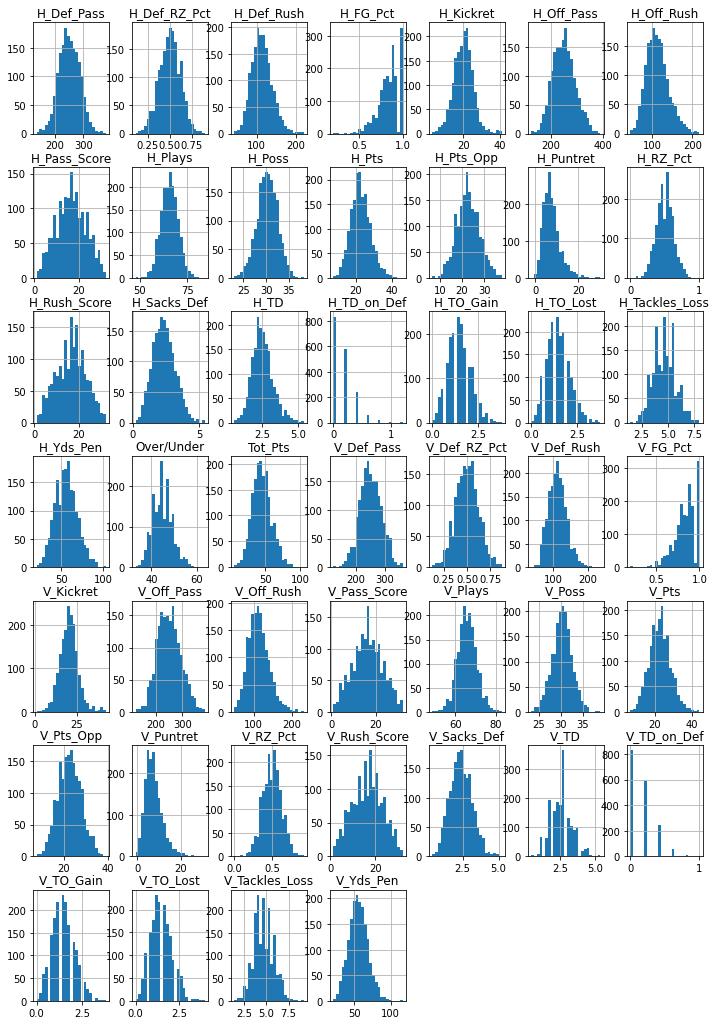

In [71]:
dfgame.iloc[:,0:46].hist(bins=25, figsize = (12,18))

In [44]:
#Calculate the correlation coefficients
corr = dfgame.corr()
#plot it in the next line
corr.style.format('{:.2f}').background_gradient(cmap='coolwarm')

<AxesSubplot:>

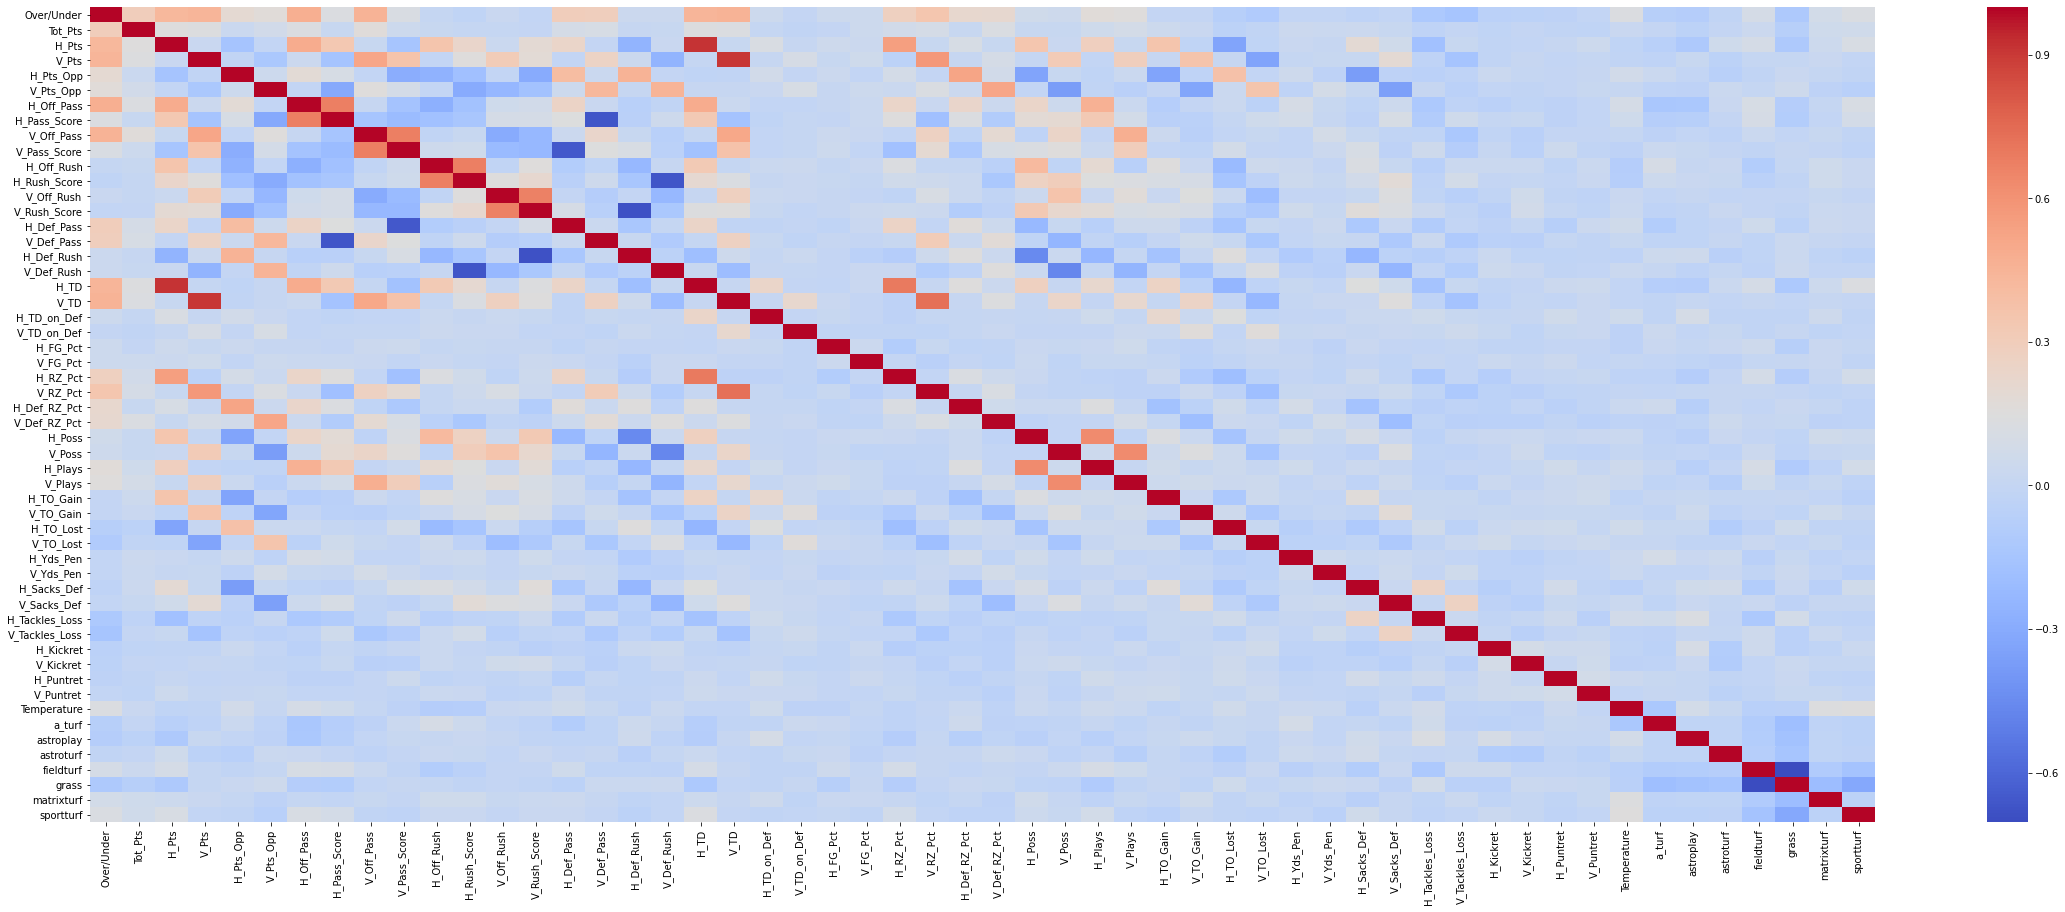

In [63]:
plt.figure(figsize=(40,15))
sns.heatmap(corr,cmap='coolwarm')

In [ ]:
Points = df